##### Install and import necessary libraries, modules, and functions

In [1]:
import os
import sys

# Add the parent directory to sys.path to import parent_package
if 'google.colab' in sys.modules:
    !git clone https://github.com/Git4amar/perf-aero-sim.git
    %cd perf-aero-sim
    %pip install -r requirements.txt -q

sys.path.append(os.path.abspath('.'))

In [2]:
import numpy as np

from ambiance import Atmosphere
from aircraft_preformance import ureg
from aircraft_preformance.helpers.airspeed import tas2cas, cas2tas, cas2mach
from aircraft_preformance.helpers.aerodynamics import c_l_steady
from aircraft_preformance.sim_climb_descent.simulation import load_or_run_simulation, simulation_descent_approach_euler, simulation_euler
from aircraft_preformance.sim_climb_descent.aerodynamic_char import gamma_steady_straight, drag, aoa_steady_staight
from aircraft_preformance.sim_climb_descent.thrust_model import max_thrust_model
from aircraft_preformance.sim_climb_descent.const import Max_Thrust_SE_SL, BPR, S, Grav_const
from aircraft_preformance.sim_climb_descent.pilot_control import pilot_pitch_control

# Aircraft performance Simulation - Climb and Descent

## Reference Simulation Document

Refer to the simulation assignment PDF document for details

[Simulation Assignment Document](./simualtion_pdf_documents/Simulation_assignment_climb_descent.pdf)

## Simplified EOM (Equations of Motion)

For a typical large aircraft, small angle approxiamtion can be used that result in simplified equations of motion for the simulation purposes. Simplified equations of motion are as following:

$$
\frac{W}{g} \frac{dV}{dt} = T - D - W sin\gamma
\tag{1}
$$

$$
\frac{W}{g} V \frac{d\gamma}{dt} = L - W
\tag{2}
$$

### EOM for steady and straight flight condition

For steady and straight flight condition (constant true airspeed and constant flight path angle), the equations of motion are as follows:

$$
T - D - W sin\gamma = 0
\tag{3}
$$

$$
L - W = 0
\tag{4}
$$

## Task 1: Initial Conditions

At 2000 meter altitude, the aircraft is assumed to be in a steady and straight flight condition (constant true airspeed and constant flight path angle). The indicated airspeed equals 170 m/s. Create a simulation model that calculates the required values for the aircraft state and control variables at initial condition (true airspeed, flight path angle, angle of attack, thrust setting). The aircraft weight at the start of the en-route climb is assumed to be equal 3,000,000 N.

### Intial Conditions

For initial conditions at 2000m, solve the EOM for steady and straight flight conditions with maximum climb thrust (95% of the maximum take-off thrust at 2000m)

#### TAS (True Airspeed)

In [3]:
# calculate TAS(True Airspeed) from IAS(Indicated Airspeed) of 170 m/s. Assumed, IAS = CAS
v_ias = ureg('170 m/s')
h = ureg('2000 m')
initial_v_tas = cas2tas(v_ias, h)
print(f'Initial true airspeed is {initial_v_tas:~P}')

Initial true airspeed is 186.08 m/s


#### Thrust Setting

In [4]:
# Pilot applies maximum climb thrust, which is 95% of the maximum take-off thrust at a altitude
max_climb_thrust = np.round(
    0.95 * 4 *  max_thrust_model(
    Max_Thrust_SE_SL,
    BPR,
    h,
    cas2mach(v_ias, h)
    ),
    2
    )
print(f'Initial thrust setting is {max_climb_thrust:~P}')

Initial thrust setting is 576.82 kN


#### Flight Path Angle

In [5]:
# consider Eq. 3 and solve for gamma (flight path angle) with maximum climb thrust

# compute aerodynamic drag
w_initial = ureg('3000000 N') # aircraft weight at start of en-route climb
aero_drag = drag(
    v_ias,
    h,
    c_l_steady(v_ias, h, w_initial, S),
    S
)

# finally compute flight path angle
flight_path_angle = gamma_steady_straight(
    max_climb_thrust,
    aero_drag,
    w_initial 
)

print(f'Initial aircraft flight path angle is {np.round(flight_path_angle.to(ureg.deg), 2):~P}')

Initial aircraft flight path angle is 7.74 deg


#### Angle of Attack

In [6]:
initial_aoa = aoa_steady_staight(
    v_ias,
    h,
    w_initial,
    S
)
print(f'Initial aircraft angle of attack is {np.round(initial_aoa.to(ureg.deg), 2):~P}')

Initial aircraft angle of attack is 4.09 deg


## Task 2: En-route Climb Simulation

Simulate the en-route climb up to an altitude of 10,000 meter. Note a suitable value for the gain $K_P$ representing the pilot should be found manually.

In [7]:
# Initial aircraft weight at the start of en-route climb
w_initial = ureg("3000000N")

# Initial altitude of the aircraft
h_start = ureg("2000m")

# Reference indicated airspeed (IAS) for the simulation
v_ref = ureg("170m/s")

# Cruise Mach number for the en-route climb
cruise_mach = 0.85

In [8]:
# suitable value for the gain K_p is 0.18 found through trail and error of the simulation
k_p = ureg('0.18 s/m')

In [9]:
# Define initial conditions for the en-route climb simulation
ics = {
    'w': w_initial,  # Initial aircraft weight at the start of en-route climb
    'h': h_start,    # Initial altitude of the aircraft
    'x': ureg('0 m'), # Initial horizontal position (assumed to be 0)
    'v_ias': v_ref,  # Reference indicated airspeed (IAS) for the simulation
}

# Define the simulation time step
time_step = ureg('0.05 s')

# Run or load the en-route climb simulation with the specified initial conditions and parameters
climb_sim_result = load_or_run_simulation(
    simulation_euler,
    ics=ics,
    time_step=time_step,
    pilot_control_model=pilot_pitch_control,
    k_p=k_p,
    v_ref=v_ref,
    cruise_mach=cruise_mach,
    phase='climb'
    )

Simulation results file found
Simulation results loaded


### Horizontal distance travelled relative to the ground vs Time

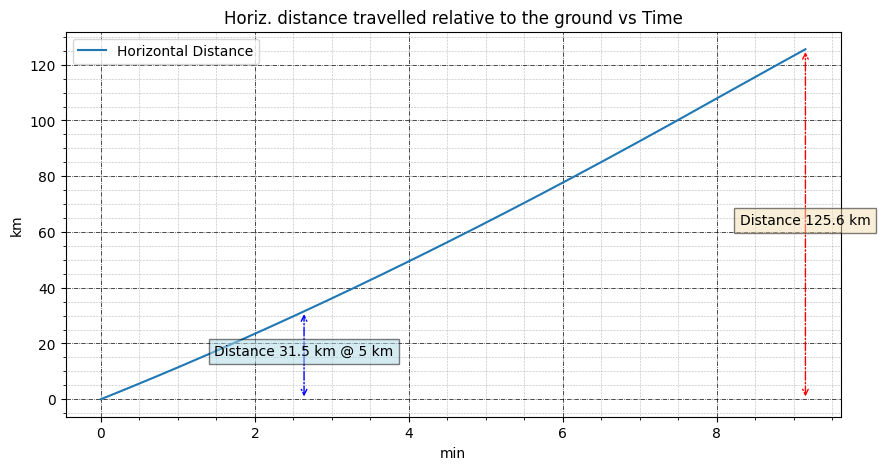

In [10]:
from aircraft_preformance.sim_climb_descent.plot_annotate import plot_horizontal_distance_vs_time
plot_horizontal_distance_vs_time(climb_sim_result)

### Altitude vs Time

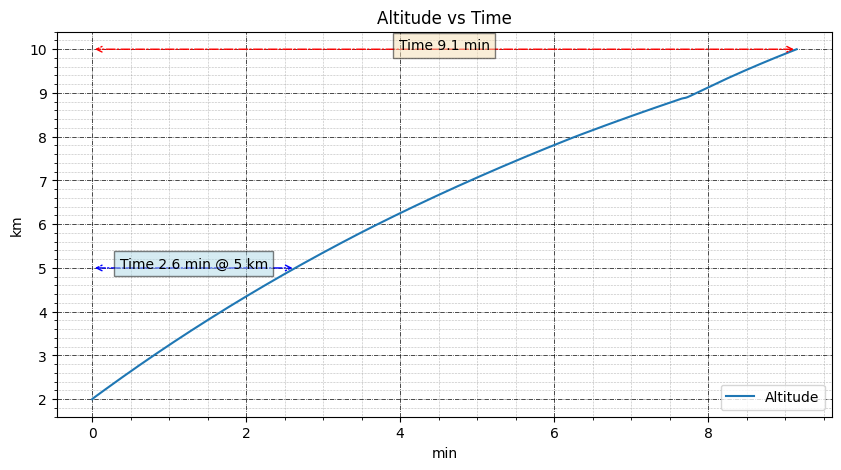

In [11]:
from aircraft_preformance.sim_climb_descent.plot_annotate import plot_altitude_vs_time
plot_altitude_vs_time(climb_sim_result)

### Altitude vs Horizontal distance travelled relative to the ground

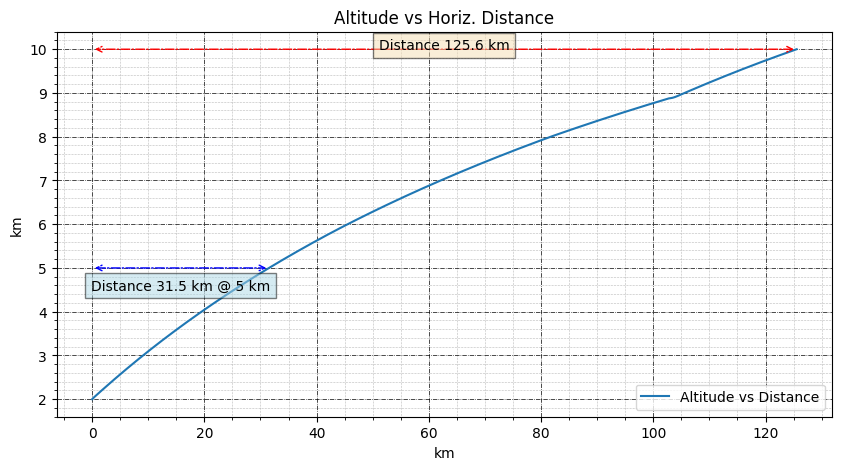

In [12]:
from aircraft_preformance.sim_climb_descent.plot_annotate import plot_altitude_vs_distance
plot_altitude_vs_distance(climb_sim_result)

### Altitude vs TAS (True Airspeed)

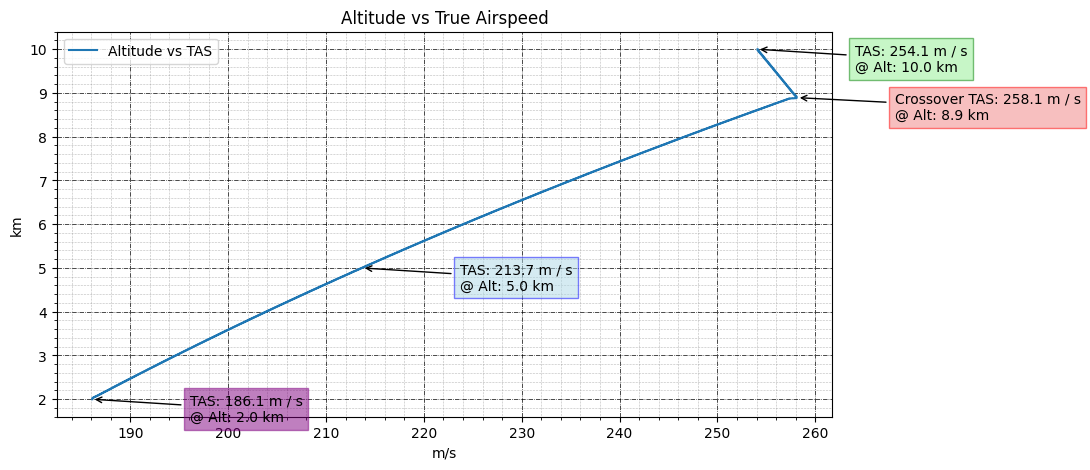

In [13]:
from aircraft_preformance.sim_climb_descent.plot_annotate import plot_altitude_vs_tas
plot_altitude_vs_tas(climb_sim_result, phase='climb')

### Mach number vs Time

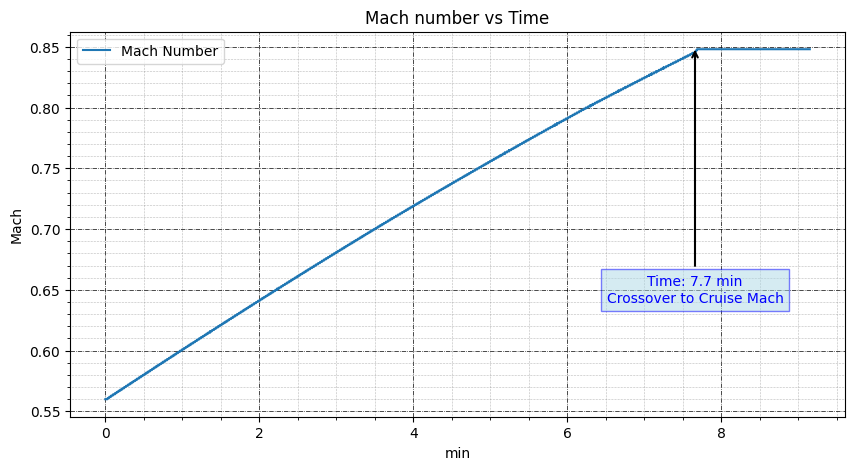

In [14]:
from aircraft_preformance.sim_climb_descent.plot_annotate import plot_mach_vs_time
plot_mach_vs_time(climb_sim_result)

### TAS (True Airspeed) vs Time

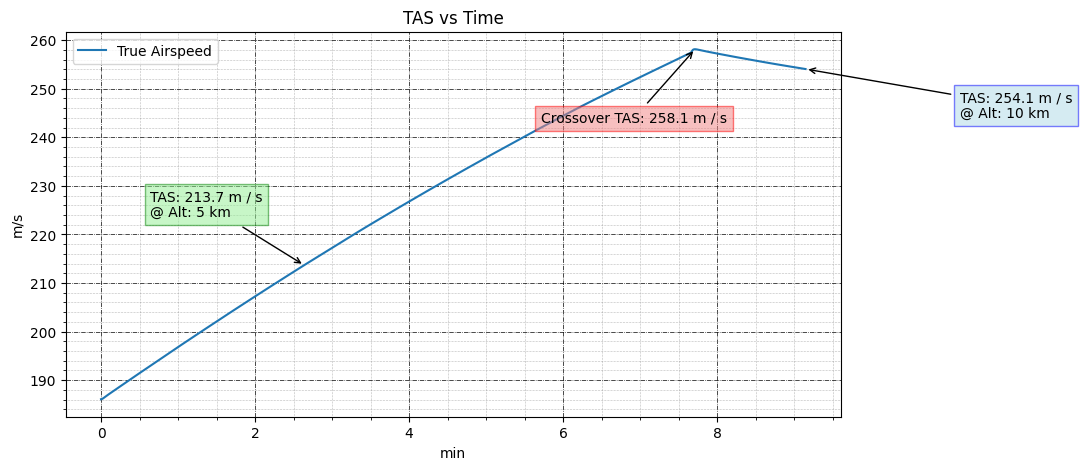

In [15]:
from aircraft_preformance.sim_climb_descent.plot_annotate import plot_tas_vs_time
plot_tas_vs_time(climb_sim_result, phase='climb')

### Fuel burn vs Time

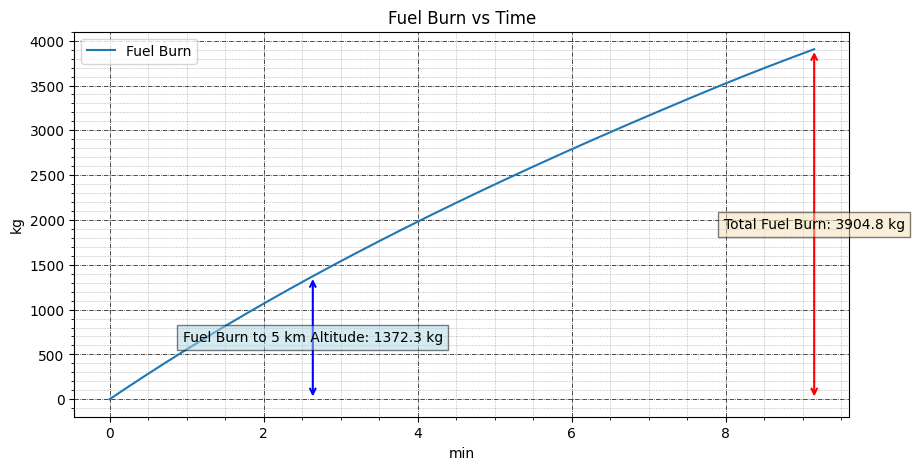

In [16]:
from aircraft_preformance.sim_climb_descent.plot_annotate import plot_fuel_burn_vs_time
plot_fuel_burn_vs_time(climb_sim_result)

### Flight path angle vs Time

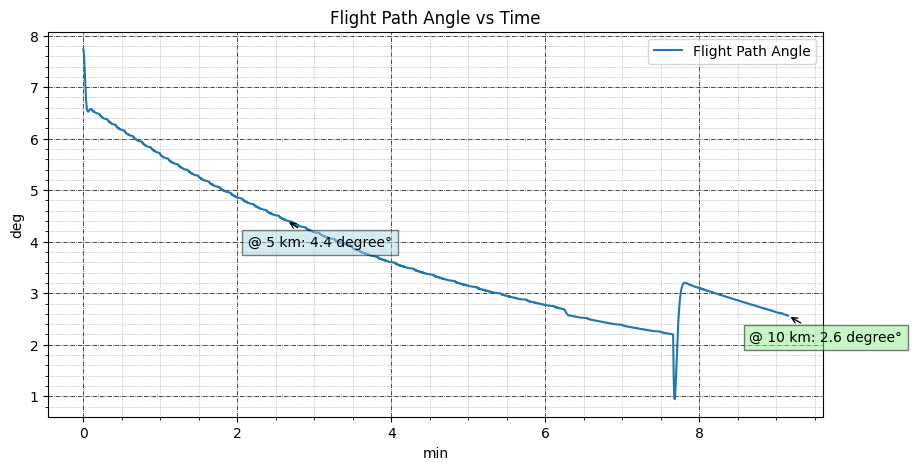

In [17]:
from aircraft_preformance.sim_climb_descent.plot_annotate import plot_gamma_vs_time
plot_gamma_vs_time(climb_sim_result, phase='climb')

### IAS (Indicated Airspeed) vs Altitude

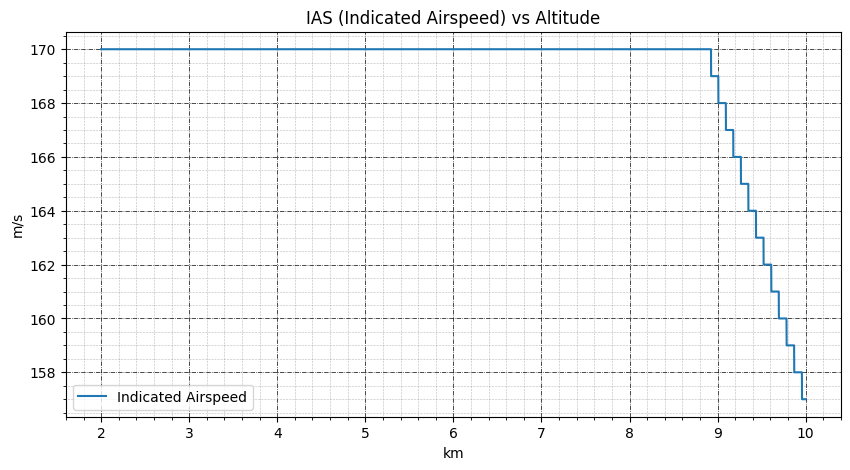

In [18]:
# plot ias vs. time for the climb phase
from aircraft_preformance.sim_climb_descent.plot_annotate import plot_ias_vs_altitude
plot_ias_vs_altitude(climb_sim_result, phase='climb')

## Task 3a: Descent Simulation

For this, a low throttle setting must be used. The minimum thrust setting (flight idle), is 5% of the maximum take-off thrust. The aircraft weight at the start of descent is assumed to be equal 2,600,000 N. The aircraft descends from 10000 m with constant cruise Mach number (M = 0.85) to a crossover altitude and then descends with a constant IAS of 170 m/s to 1000 m.

In [19]:
# Define initial conditions for the descent simulation
ics = {
    'w': ureg('2600000N'),  # Aircraft weight at the start of descent
    'h': ureg('10000m'),    # Initial altitude of the aircraft
    'x': ureg('0m'),        # Initial horizontal position (assumed to be 0)
    # Calculate initial IAS (Indicated Airspeed) equivalent to 0.85 cruise Mach at 10,000 m altitude
    'v_ias': tas2cas(
        cruise_mach * Atmosphere(10000).speed_of_sound[0] * ureg('m/s'),
        ureg('10000m')
    ),
}

# Define the simulation time step
time_step = ureg('0.05 s')

# Run or load the descent simulation with the specified initial conditions and parameters
descent_sim_result = load_or_run_simulation(
    simulation_euler,
    ics=ics,
    time_step=time_step,
    pilot_control_model=pilot_pitch_control,
    k_p=k_p,
    v_ref=v_ref,
    cruise_mach=cruise_mach,
    phase='descent'
    )

Simulation results file found
Simulation results loaded


### Horizontal distance travelled relative to the ground vs Time

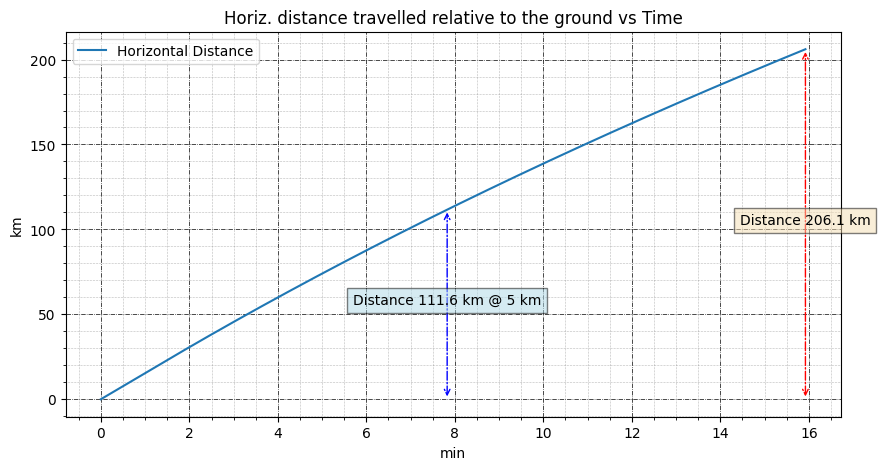

In [20]:
from aircraft_preformance.sim_climb_descent.plot_annotate import plot_horizontal_distance_vs_time
plot_horizontal_distance_vs_time(descent_sim_result)

### Altitude vs Time

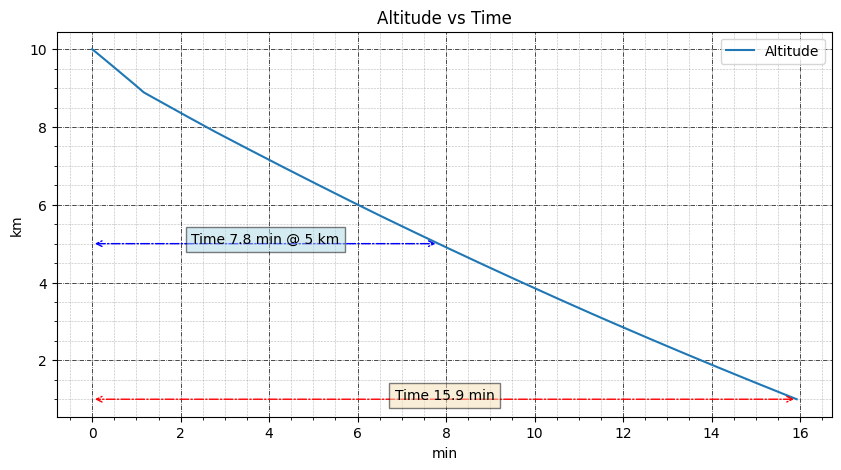

In [21]:
# Plot altitude vs. time for the descent simulation
from aircraft_preformance.sim_climb_descent.plot_annotate import plot_altitude_vs_time
plot_altitude_vs_time(descent_sim_result)

### Altitude vs Horizontal distance travelled relative to the ground

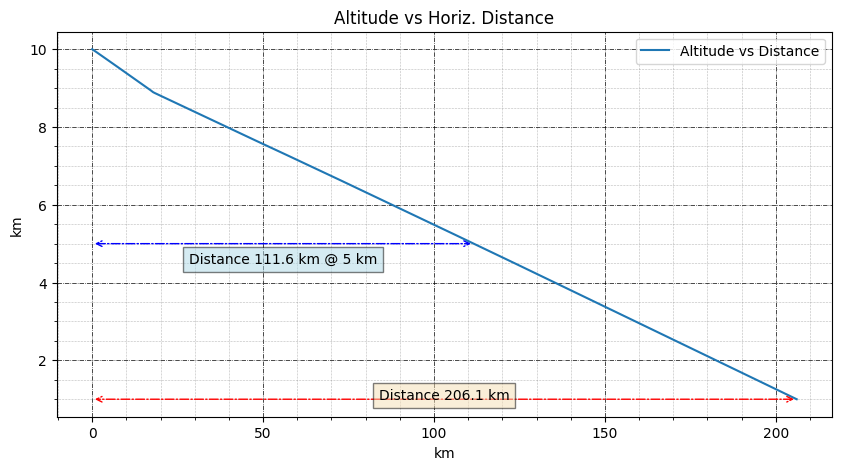

In [22]:
# Plot altitude vs. horizontal distance for the descent simulation
from aircraft_preformance.sim_climb_descent.plot_annotate import plot_altitude_vs_distance
plot_altitude_vs_distance(descent_sim_result)

### Altitude vs TAS (True Airspeed)

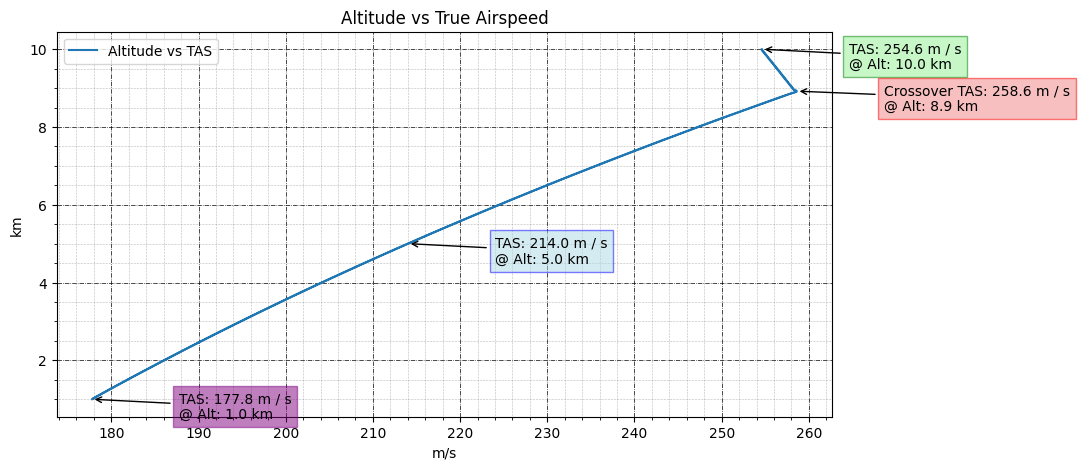

In [23]:
# Plot altitude vs. tas for the descent simulation
from aircraft_preformance.sim_climb_descent.plot_annotate import plot_altitude_vs_tas
plot_altitude_vs_tas(descent_sim_result, phase='descent')

### Mach number vs Time

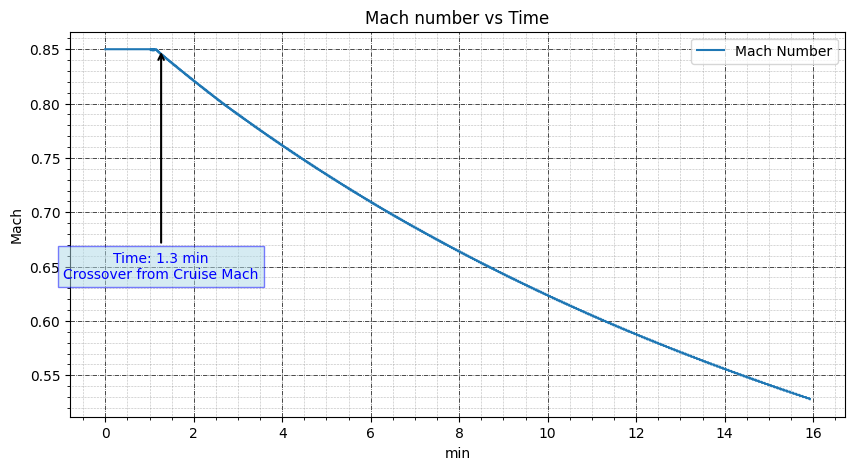

In [24]:
# plot mach number vs. time for the descent simulation
from aircraft_preformance.sim_climb_descent.plot_annotate import plot_mach_vs_time
plot_mach_vs_time(descent_sim_result)

### TAS (True Airspeed) vs Time

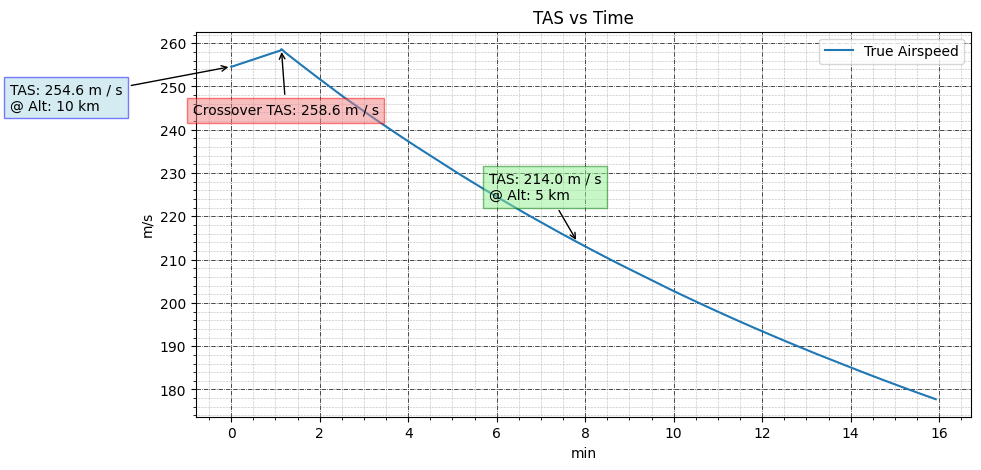

In [25]:
# Plot tas vs. time for the descent simulation
from aircraft_preformance.sim_climb_descent.plot_annotate import plot_tas_vs_time
plot_tas_vs_time(descent_sim_result, phase='descent')

### Fuel burn vs Time

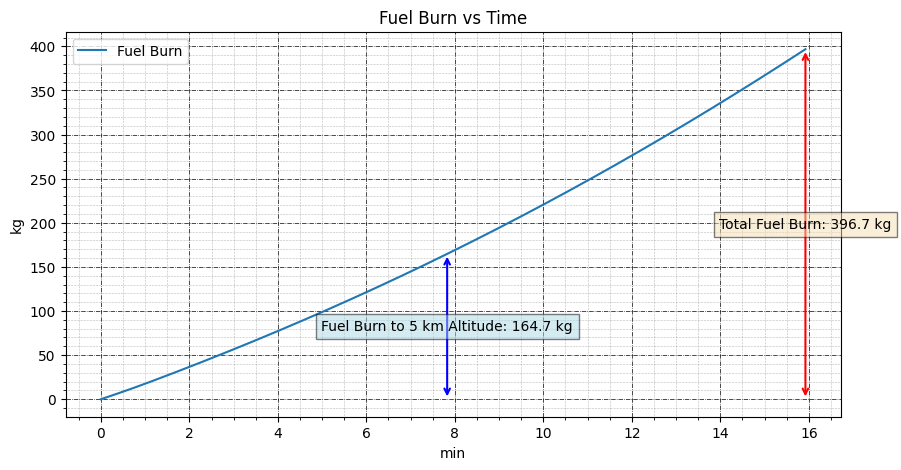

In [26]:
# Plot fuel burn vs. time for the descent simulation
from aircraft_preformance.sim_climb_descent.plot_annotate import plot_fuel_burn_vs_time
plot_fuel_burn_vs_time(descent_sim_result)

### Flight path angle vs Time


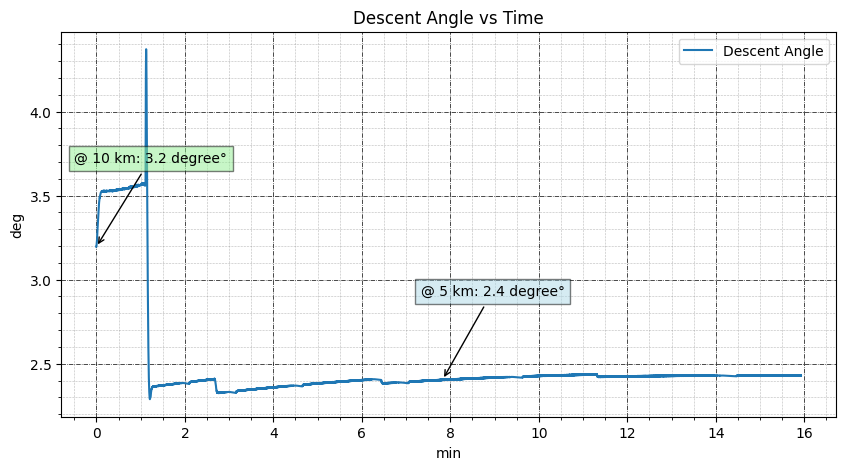

In [27]:
# Plot flight path angle vs. time for the descent simulation
from aircraft_preformance.sim_climb_descent.plot_annotate import plot_gamma_vs_time
plot_gamma_vs_time(descent_sim_result, phase='descent')

### IAS (Indicated Airspeed) vs Altitude

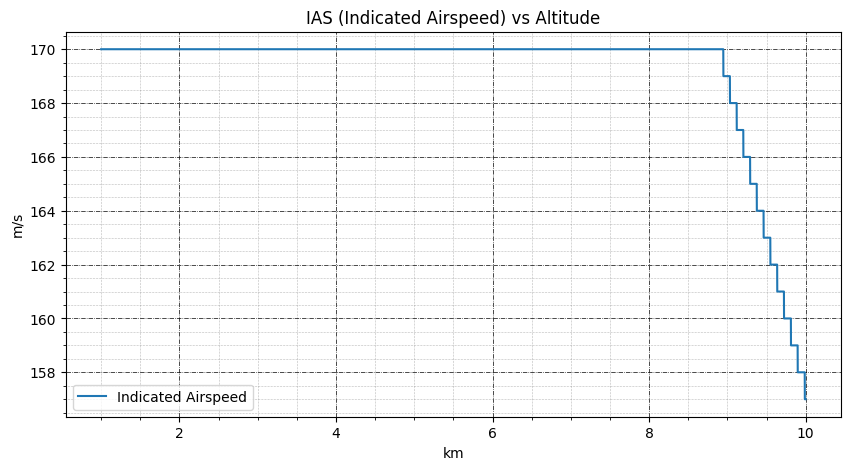

In [28]:
# plot IAS vs. altitude for the descent simulation
from aircraft_preformance.sim_climb_descent.plot_annotate import plot_ias_vs_altitude
plot_ias_vs_altitude(descent_sim_result, phase='descent')

## Task 3b: Approach phase of descent

In the final approach phase, the aircraft descends from 1000 m to a screen height of 35 ft along at a constant glide slope of $3 \degree$ with a constant approach speed of 146 kts. Since both the flight path angle and the airspeed are controlled by the pilot, both throttle and pitch changes are applied by the pilot during this portion of the descent.

In [29]:
v_ref = ureg('146kts')
glideslope_angle = ureg('3 deg')
screen_h = ureg('35ft')

# Define initial conditions for the descent simulation
w_initial = ics['w'] - (descent_sim_result['fuel_burn'][-1] * Grav_const) # Aircraft weight at the start of descent approach phase
ics = {
    'w': w_initial, 
    'h': ureg('1000m'),    # Initial altitude of the aircraft at the start of descent approach phase
    'x': ureg('0 m'),        # Initial horizontal position (the last position from descent simulation)
}

# Define the simulation time step
time_step = ureg('0.05 s')

# # Run or load the descent simulation with the specified initial conditions and parameters
descent_approach_sim_result = load_or_run_simulation(
    simulation_descent_approach_euler,
    ics=ics,
    time_step=time_step,
    v_ref=v_ref,
    glideslope_angle=glideslope_angle,
    screen_h=screen_h,
    phase="descent_approach"
)

Simulation results file found
Simulation results loaded


### Horizontal distance travelled relative to the ground vs Time


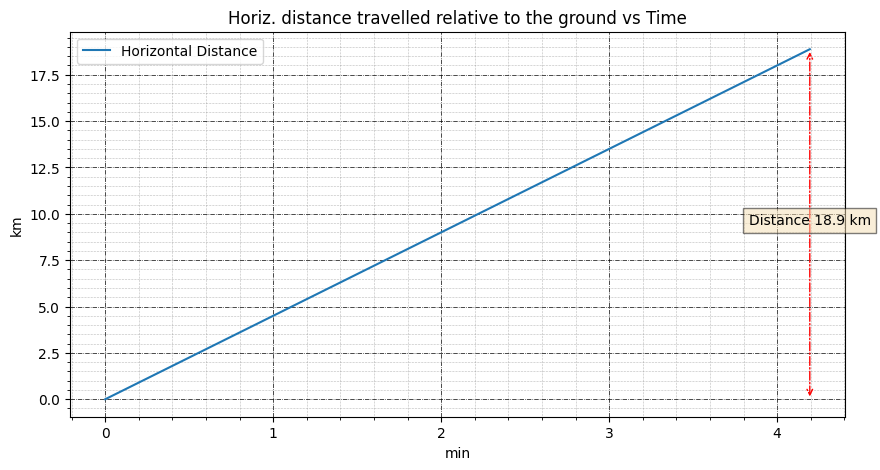

In [30]:
# Plot horizontal distance vs. time for the descent approach simulation
from aircraft_preformance.sim_climb_descent.plot_annotate import plot_horizontal_distance_vs_time
plot_horizontal_distance_vs_time(descent_approach_sim_result)

### Altitude vs Time

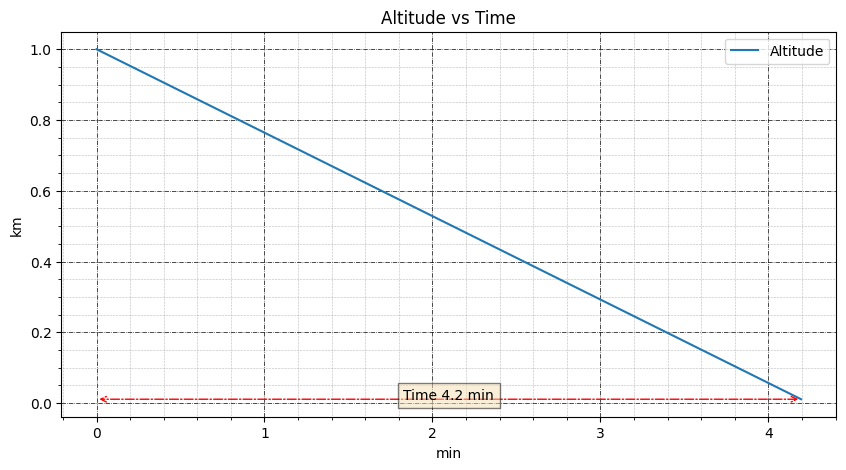

In [31]:
# Plot altitude vs. time for the descent approach simulation
from aircraft_preformance.sim_climb_descent.plot_annotate import plot_altitude_vs_time
plot_altitude_vs_time(descent_approach_sim_result)

### Altitude vs Horizontal distance travelled relative to the ground

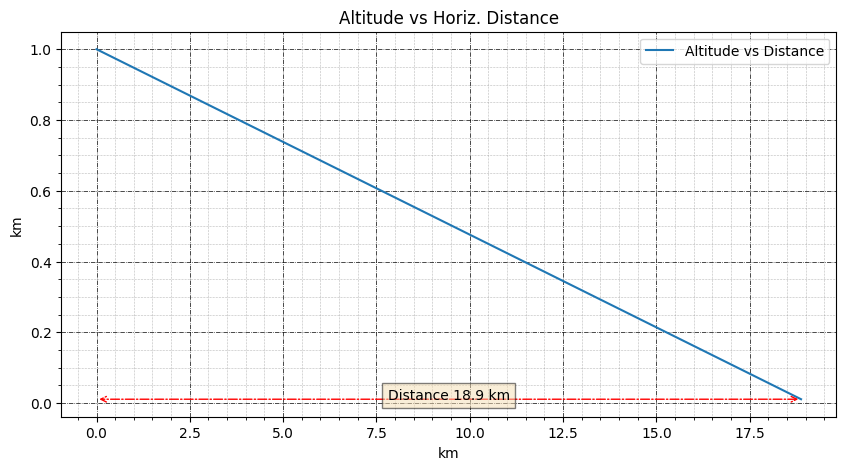

In [32]:
# Plot altitude vs. horizontal distance for the descent approach simulation
from aircraft_preformance.sim_climb_descent.plot_annotate import plot_altitude_vs_distance
plot_altitude_vs_distance(descent_approach_sim_result)

### Altitude vs TAS (True Airspeed)

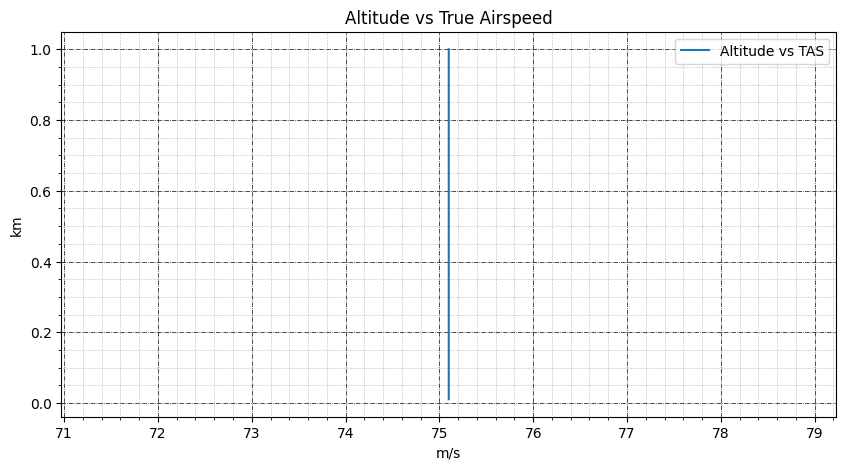

In [33]:
# Plot altitude vs. tas for the descent approach simulation
from aircraft_preformance.sim_climb_descent.plot_annotate import plot_altitude_vs_tas
plot_altitude_vs_tas(descent_approach_sim_result, phase='descent_approach')

### Fuel burn vs Time


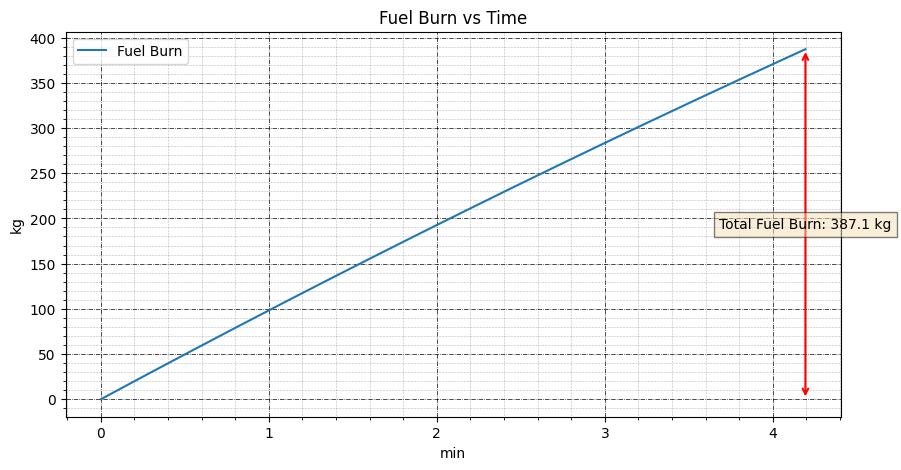

In [34]:
# plot fuel burn vs. time for the descent approach simulation
from aircraft_preformance.sim_climb_descent.plot_annotate import plot_fuel_burn_vs_time
plot_fuel_burn_vs_time(descent_approach_sim_result)

### AoA (Angle of Attack) angle vs Time

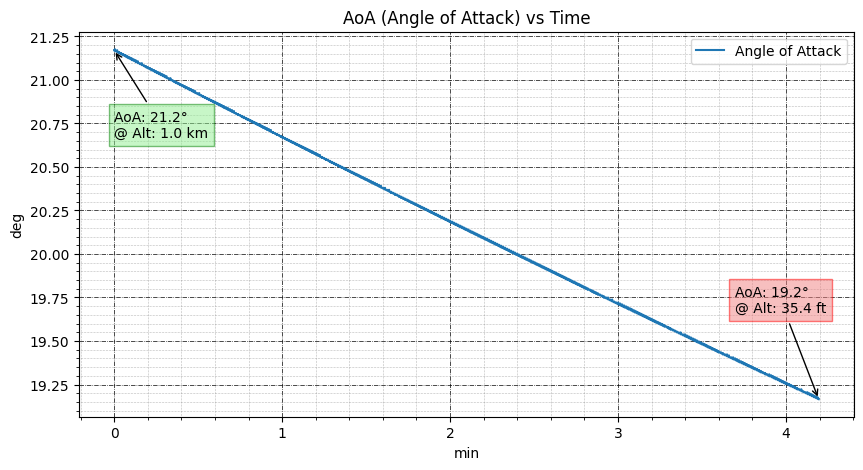

In [35]:
# plot AoA vs. time for the descent approach simulation
from aircraft_preformance.sim_climb_descent.plot_annotate import plot_aoa_vs_time
plot_aoa_vs_time(descent_approach_sim_result)

### Pitch Angle Setting vs Time

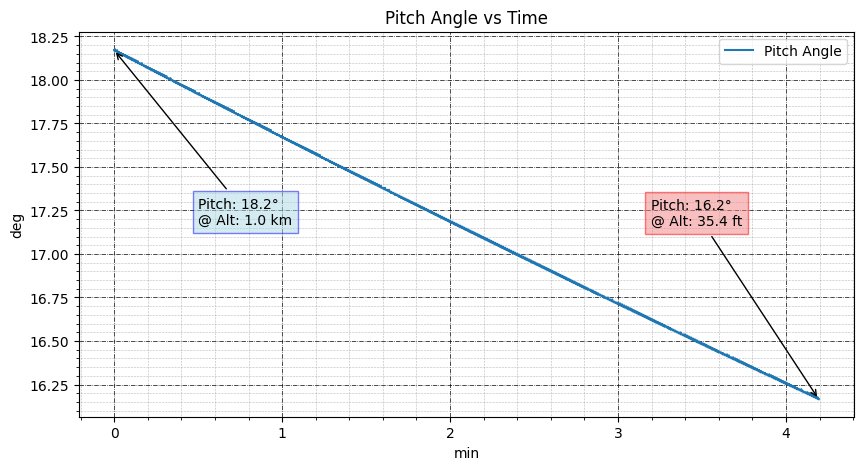

In [36]:
# plot pitch angle vs. time for the descent approach simulation
from aircraft_preformance.sim_climb_descent.plot_annotate import plot_pitch_angle_vs_time
plot_pitch_angle_vs_time(descent_approach_sim_result)

### Thrust Setting vs Time

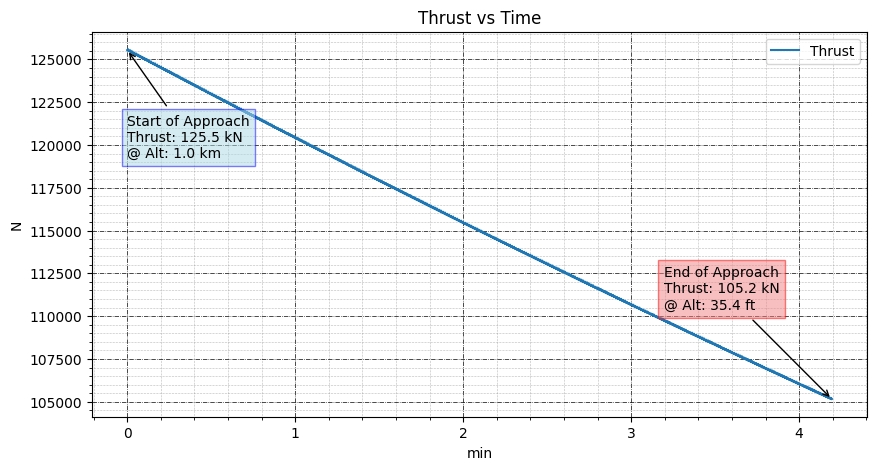

In [37]:
# plot thrust vs. time for the descent approach simulation
from aircraft_preformance.sim_climb_descent.plot_annotate import plot_thrust_vs_time
plot_thrust_vs_time(descent_approach_sim_result)

### IAS (Indicated Airspeed) vs Altitude

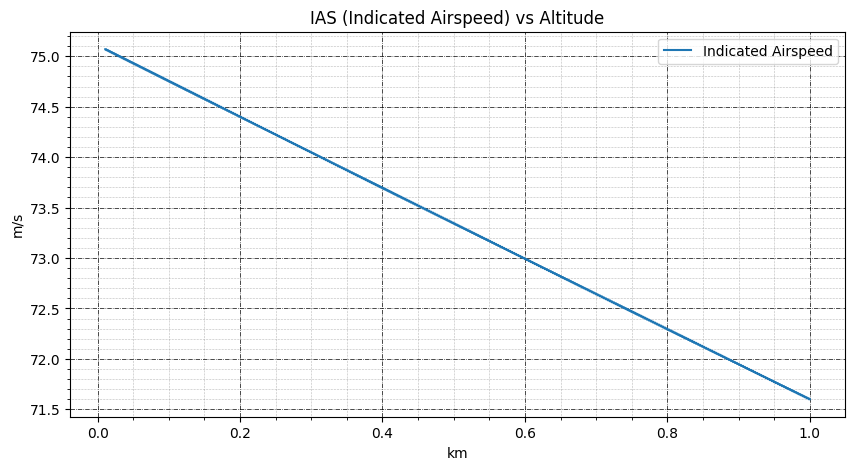

In [38]:
# plot ias vs. altitude for the descent approach simulation
from aircraft_preformance.sim_climb_descent.plot_annotate import plot_ias_vs_altitude
plot_ias_vs_altitude(descent_approach_sim_result, phase='descent_approach')